<center><img src="RENCI-Official-Logo-transparent.png" width=400 height=100 />

<font size="5">
    <center>
Timeseries Extraction Demonstration Notebook from the RENCI/NOAA 43-year reanalysis
    
        Version 0.2, 30 Aug 2022
    Written by Jim McManus, Jeff Tilson, and Brian Blanton, RENCI
    Funded by NOAA
</font>

<font size="4">

The Renaissance Computing Institute, in collaboration with NOAA's ..., is computing a high-resolution coastal reanalysis dataset using the ADCIRC storm surge, wind-wave, and tide model, and the ECMWF's ERA5 atmospheric reanalisys, spanning the period 1979-2021.  The resulting datasets are in the native ADCIRC/netCDF format, which can complicate working with the large datasets due to the triangular grid used by ADCIRC.  This notebook demostrates the use of a Python package that provides easy access to the datasets for water level and bulk wind wave parameters at user-specified lon/lat points. 
</font>
<hr>

## Solution details
The ADCIRC model is forced with tides from TPXO and ECMWF's ERA5 10-m wind velocities and sea level pressure.  The ERA5 annual datasets were subsetted to cover the ADCIRC HSOFS grid, shown here:
<hr>

## User inputs
The demonstration needs 3 inputs from the user, specified in the box below.
1. Upload a csv file of lon, lat coordinates, with a header line that names the coordinate columns with "lon" and "lat".  The order does not matter. There are 4 example/test files in the testdata directory.
 * **NOAA_Stations_141.csv** contains 141 NOAA stations.  
 * **hsofs_200grid_lonlat.csv** contains a random selection of 200 nodes from the NOAA HSOFS ADCIRC grid.
 * **1point.csv** contains 1 point
 * **hsofs_2grid_lonlat.csv** contains 2 points, one "on land" and the other in water.  The process for the first point will result in all NaNs for the returned timeseries.
2. Specify the variable to extract from the Reanalysis dataset.  The currently available variables are 'water level', 'wave height', 'wave period', 'wave direction'
3. Specify the years to extract using the slider.  The year range is inclusive.

Then, click the Submit button.

### import the interface package and execute the interface class

In [1]:
# import the interface package and execute the interface class
from reAnalysisInterface import demoInterface
d = demoInterface()

HTML(value='\n            <style>\n                /* enlarges the default jupyter cell outputs, can revert by…

                           P1
1979-01-01 01:00:00  0.488392
1979-01-01 02:00:00  0.485405
1979-01-01 03:00:00  0.296576
1979-01-01 04:00:00 -0.074963
1979-01-01 05:00:00 -0.357004


<AxesSubplot:>

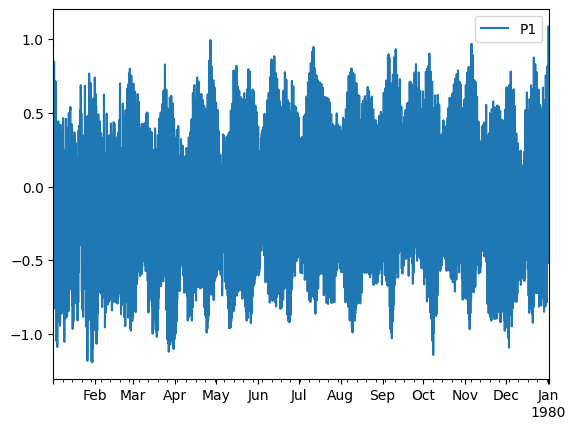

In [2]:
# Access DataFrame of data extracted for stations, outside of widgets
print(d.df_product_data.head())

d.df_product_data.plot()

In [ ]:
# Access meta data DataFrame, outside of widgets
#d.df_product_metadata.head()

In [ ]:
# Access DataFrame of excluded stations, outside of widgets
#d.df_excluded.head()

### runtime estimates

| Np | Ny | time [sec] |
| -  | -  |     -      |
|1   |  1 |   20-30       |
|1   | 43 | 200        |
